# \[03\] Visualize User Events

## Setup Spark Session

for a detailed description what is done here see [01-setup-spark-session.ipynb](01-setup-spark-session.ipynb)


In [8]:
# EVENT_DATA_URL = "s3a://udacity/sparkify/sparkify_event_data.json"
EVENT_DATA_URL = "s3a://udacity-dsnd/sparkify/mini_sparkify_event_data.json"

CLEAN_DATA_URL = EVENT_DATA_URL.replace("/sparkify/", "/sparkify/output/02-cleaned-")

EXECUTOR_INSTANCES = 2
EXECUTOR_MEM = '6g'

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from cryptography.fernet import Fernet
import base64
import socket

!./install-s3-jars.sh

def decrypt(encrypted_text):
    """
    decrypts an encrypted text. The seed (master-password) for decryption is read from the file ".seed.txt"
    
    Input: encrypted_text
    
    Output: the decrypted text. If the text was not encrypted with the same seed, 
            an exception is raised.
    """
    with open('.seed.txt') as f:
        seed = f.read().strip()
    return Fernet(base64.b64encode((seed*32)[:32].encode('ascii')).decode('ascii')).decrypt(encrypted_text.encode('ascii')).decode('ascii')

AWS_ACCESS_KEY_ID='V6ge1JcQpvyYGJjb'
AWS_SECRET_ACCESS_KEY = decrypt('gAAAAABkDFI6865LaVJVgtTYo0aMx9-JTPbTo6cwOUjg5eNNPsZhBDoHbRZ8xuXQT0ImNfvqcecZuoJd1VzYQEpBaxyCnKvosii8O1KeqoL2NwKdKtL_AUfT4eW4dvJVP--VjEvc0gB4')
OWN_IP=socket.gethostbyname(socket.gethostname())
APP_NAME = "Sparkify"
SPARK_MASTER = "spark://bit-spark-master-svc.spark.svc.cluster.local:7077"
S3_HOST = "minio-api-service.minio.svc"

print(f'### SETUP SPARK SESSION "{APP_NAME}"')
spark = SparkSession.builder \
    .master(SPARK_MASTER) \
    .config("spark.jars","/home/jovyan/jars/aws-java-sdk-bundle-1.11.1026.jar,/home/jovyan/jars/hadoop-aws-3.3.2.jar") \
    .config("spark.driver.host", OWN_IP) \
    .config("spark.hadoop.fs.s3a.endpoint", S3_HOST) \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.access.key", AWS_ACCESS_KEY_ID) \
    .config("spark.hadoop.fs.s3a.secret.key", AWS_SECRET_ACCESS_KEY) \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.executor.instances", EXECUTOR_INSTANCES) \
    .config("spark.executor.memory", EXECUTOR_MEM) \
    .appName(APP_NAME).getOrCreate()
print(f"Spark version: {spark.version}")
sc = spark.sparkContext
sc.setLogLevel("WARN")



### SETUP SPARK SESSION "Sparkify"
Spark version: 3.3.2


## Cleaned Data

There are two possibilities, how to get the cleaned data.  
Load the saved data from S3 or reapply the transformations, e.g. if writing to S3 is not possible.  

**Only apply one of both possibilities**

### Possibility 1 - Load from S3

In [9]:
print(f"### LOAD DATA {CLEAN_DATA_URL}")
df = spark.read.json(CLEAN_DATA_URL)
print(f"### PERSIST df")
df_persist = df.persist()
df = df_persist

### LOAD DATA s3a://udacity-dsnd/sparkify/output/02-cleaned-mini_sparkify_event_data.json
### PERSIST df


### Possibility 2 - Apply Transformations

For a detailed description what is done here see [02-data-introspection.ipynb](02-data-introspection.ipynb)

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import IntegerType

def norm_colname(name):
    """
    Input: name which can contain spaces with upper and lowercase letters.
    Output: all spaces replaced with an underscore and all letters converted to lowercase
    """
    return name.replace(' ', '_').lower()

print(f"### DROP UNUSED COLUMNS")
df = df.drop("artist", "auth", "firstName", "lastName", "length", "location", "method", "song", "userAgent")
print(f"### REMOVE EMPTY USERID")
df = df.filter(df.userId != '')
print(f"### ADD ID")
w = Window().orderBy("ts")
df = df.withColumn("id", F.row_number().over(w))
print(f"### VECTORIZE PAGE FEATURES")
page_features = df.groupBy("id").pivot("page").agg(F.lit(1)).na.fill(0)
page_features = page_features.toDF(*(("pg_"+norm_colname(col)) if col!="id" else "id" for col in page_features.columns))
df = df.join(page_features, "id")
print(f"### VECTORIZE LEVEL FEATURE")
df = df.withColumn("paid", (df.level == 'paid').cast('int'))
df = df.drop("level")
print(f"### VECTORIZE GENDER FEATURE")
df = df.withColumn("male", (df.gender == 'M').cast('int'))
df = df.drop("gender")
print(f"### VECTORIZE STATUS FEATURES")
status_features = df.groupBy("id").pivot("status").agg(F.lit(1)).na.fill(0)
status_features = status_features.toDF(*(("status_"+col) if col != "id" else "id" for col in status_features.columns)).drop("status_200")
df = df.join(status_features, "id")
df = df.drop("status")
print(f"### ADD SID")
df_sess_user = df.select("sessionId", "userId").dropDuplicates()
w = Window().orderBy("sessionId", "userId")
df_sess_user = df_sess_user.withColumn("sid", F.row_number().over(w))
df = df.join(df_sess_user, ["sessionId", "userId"])
df_session_start = df.groupBy("sid").agg(F.min("id").alias("id")).drop("sid").withColumn("session_start", F.lit(1).cast("int"))
df = df.join(df_session_start, "id", how="outer").fillna(0)
df = df.drop("sessionId", "itemInSession")
print(f"### PERSIST df")
df_persist = df.persist()
df = df_persist

## Imports

Here are all imports which are needed in the later cells.

In [12]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import IntegerType

## Define Page Metadata

For the visualization we need to define how each page event should be visualized (id is the y axis = height).  
The events are groupd by functionality.
Error is at the bottom and has red color.  
Then there are static page views: Home/Help/About in gray.  
...  
And the top two red events are the two churning: Submit-Downgrade/Cancellation-Confirmation  

In [13]:
page_info = {
 'Error':                     {'id': 5, 'color': 'red'},

 'Home':                      {'id': 10, 'color': 'gray'},
 'Help':                      {'id': 11, 'color': 'orange'},
 'About':                     {'id': 12, 'color': 'gray'},

 'Login':                     {'id': 14, 'color': 'gray'},
 'Logout':                    {'id': 15, 'color': 'gray'},
    
 'Settings':                  {'id': 17, 'color': 'gray'},
 'Save Settings':             {'id': 18, 'color': 'gray'},
 'Add Friend':                {'id': 19, 'color': 'blue'},

 'Thumbs Down':               {'id': 22, 'color': 'orange'},
 'Thumbs Up':                 {'id': 23, 'color': 'blue'},
 'Add to Playlist':           {'id': 24, 'color': 'blue'},
 'NextSong':                  {'id': 25, 'color': 'gray'},

 'Roll Advert':               {'id': 27, 'color': 'gray'},

 'Register':                  {'id': 30, 'color': 'yellow'},
 'Upgrade':                   {'id': 31, 'color': 'yellow'},

 'Submit Registration':       {'id': 34, 'color': 'green'},
 'Submit Upgrade':            {'id': 35, 'color': 'green'},

 'Downgrade':                 {'id': 38, 'color': 'orange'},
 'Cancel':                    {'id': 39, 'color': 'orange'},

 'Submit Downgrade':          {'id': 42, 'color': 'red'},
    
 'Cancellation Confirmation': {'id': 44, 'color': 'red'},

}

In [22]:
df_order = df.groupBy("userId").agg(F.count("id").alias("events"), F.sum("pg_submit_downgrade").alias("downs"), F.sum("pg_cancellation_confirmation").alias("cancels")).sort(F.desc("downs"), F.desc("cancels"))
df_order.show(20)

+------+------+-----+-------+
|userId|events|downs|cancels|
+------+------+-----+-------+
|   140|  6880|    3|      0|
|    39|  9632|    3|      0|
|    61|  1976|    2|      0|
|    85|  4370|    2|      0|
|    13|  1654|    2|      0|
|100018|  1288|    2|      0|
|100004|  1245|    2|      0|
|   131|  1863|    2|      0|
|200003|   977|    2|      0|
|200023|  3769|    2|      0|
|    20|  2195|    2|      0|
|    35|  2005|    2|      0|
|    54|  3437|    1|      1|
|100015|  1050|    1|      1|
|100025|   623|    1|      1|
|   103|  1310|    1|      1|
|200011|   848|    1|      1|
|100009|   671|    1|      1|
|100012|   600|    1|      1|
|    12|  1064|    1|      1|
+------+------+-----+-------+
only showing top 20 rows



In [24]:
user_ids_ordered = [row.userId for row in df_order.collect()]

user_ids_selected = user_ids_ordered[0:100:10]

In [25]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def get_user_events(userId):
    return df.where(df.userId == userId).sort("ts").select("ts", "page").collect()
    
def plot_user_events(userId):
    user_events  = get_user_events(userId)
    y = [page_info[ue.page]["id"] for ue in user_events]
    x1 = np.linspace(0, len(y)-1, len(y))
    x2 = [int(ue.ts) for ue in user_events]
    c = [page_info[ue.page]["color"] for ue in user_events]
    plt.scatter(x1, y, c=c)
    plt.ylabel("Event");
    plt.yticks([pi["id"] for pi in page_info.values()], list(page_info.keys()), rotation=30)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.show()

    plt.scatter(x2, y, c=c)
    plt.ylabel("Event");
    plt.yticks([pi["id"] for pi in page_info.values()], list(page_info.keys()), rotation=30)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.show()
    

user 140


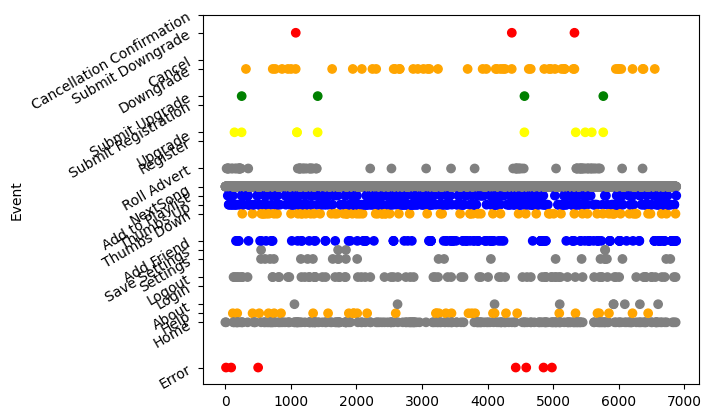

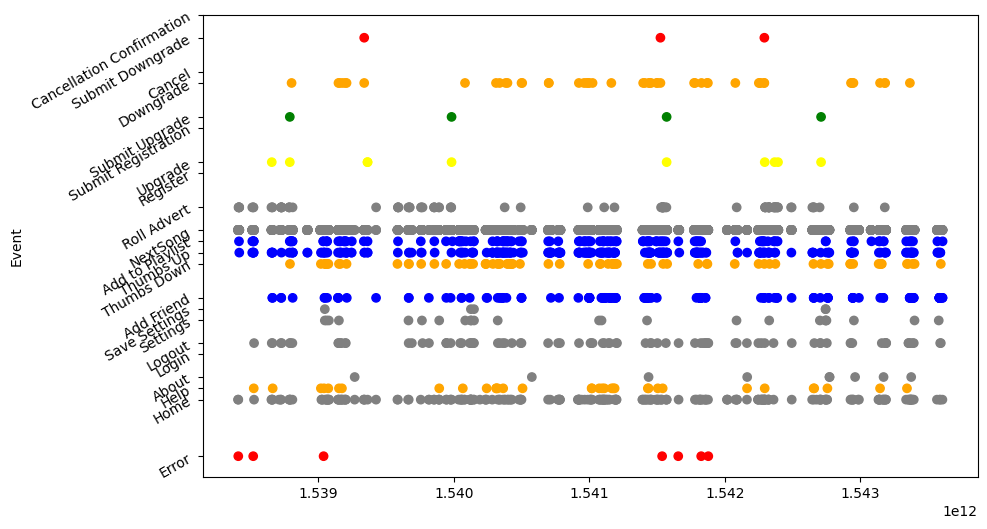

user 13


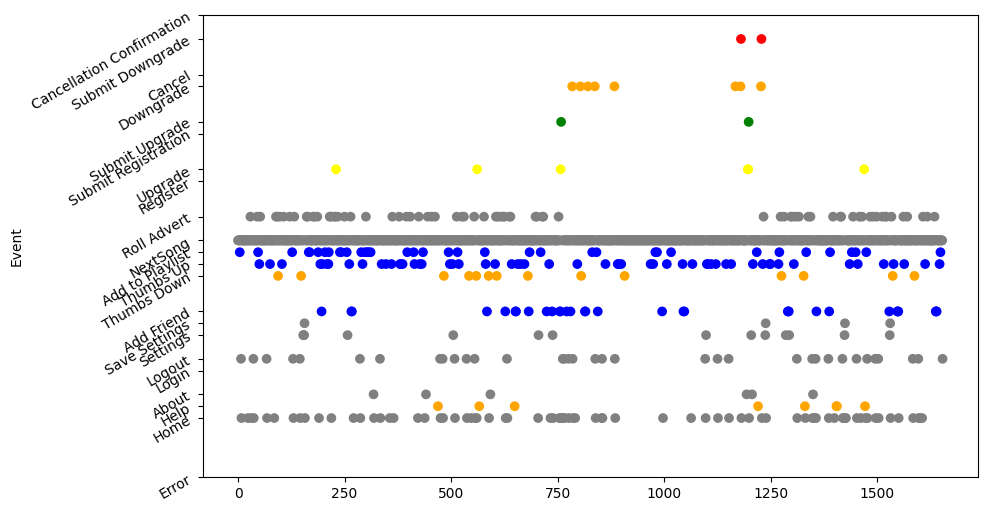

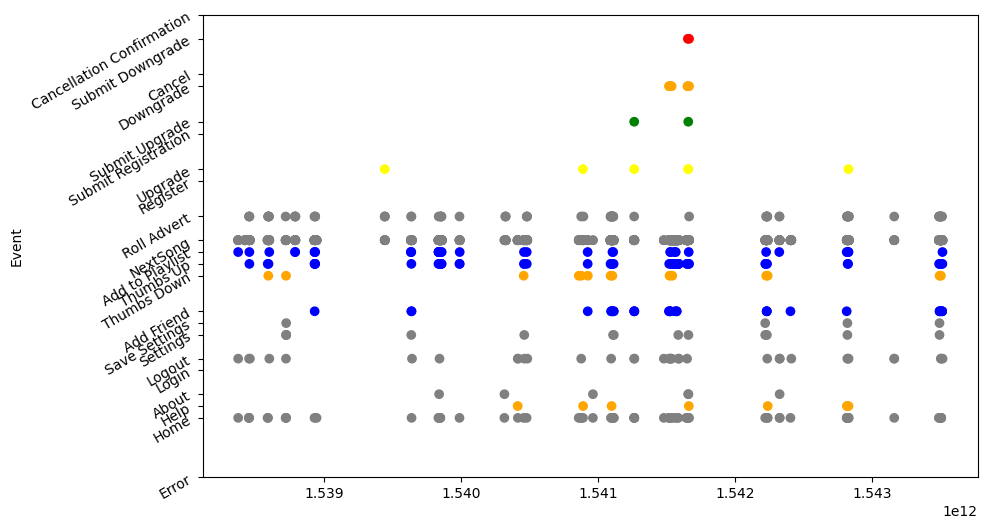

user 12


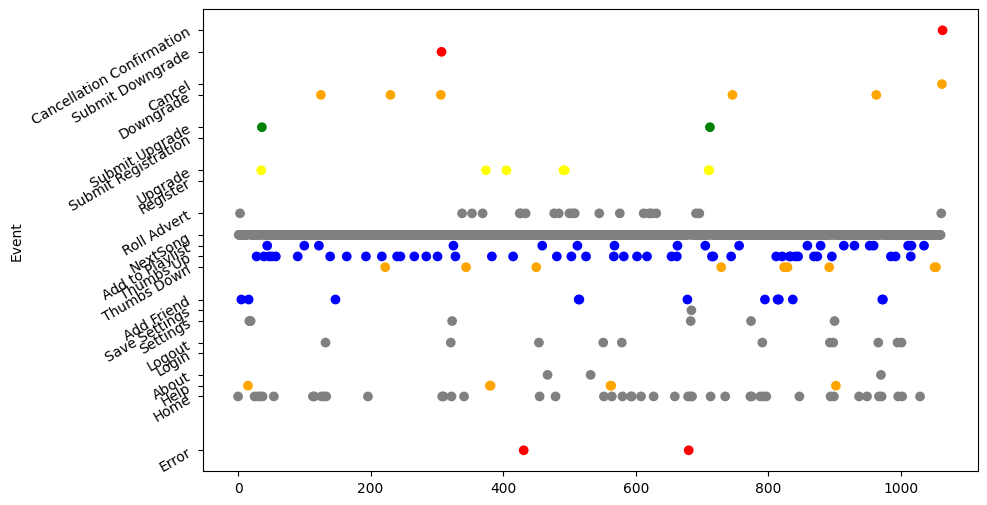

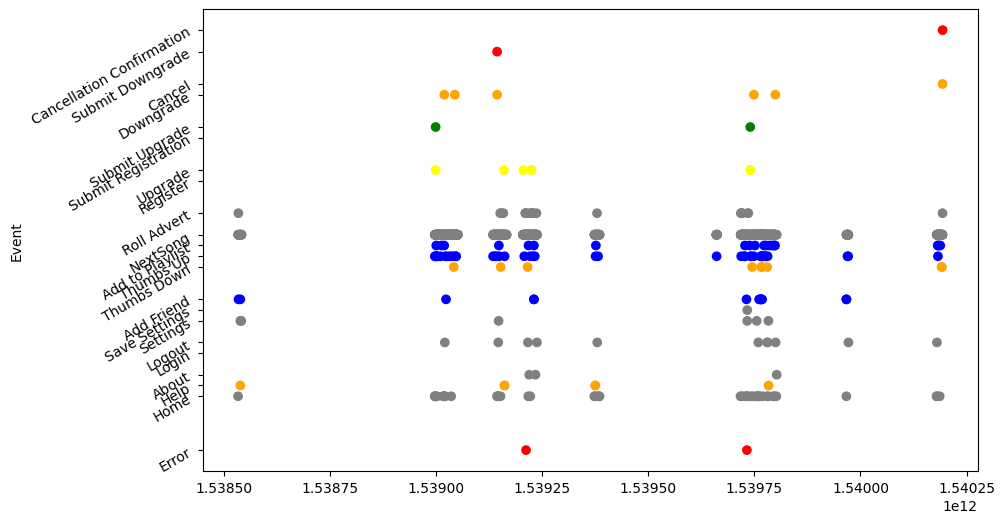

user 300011


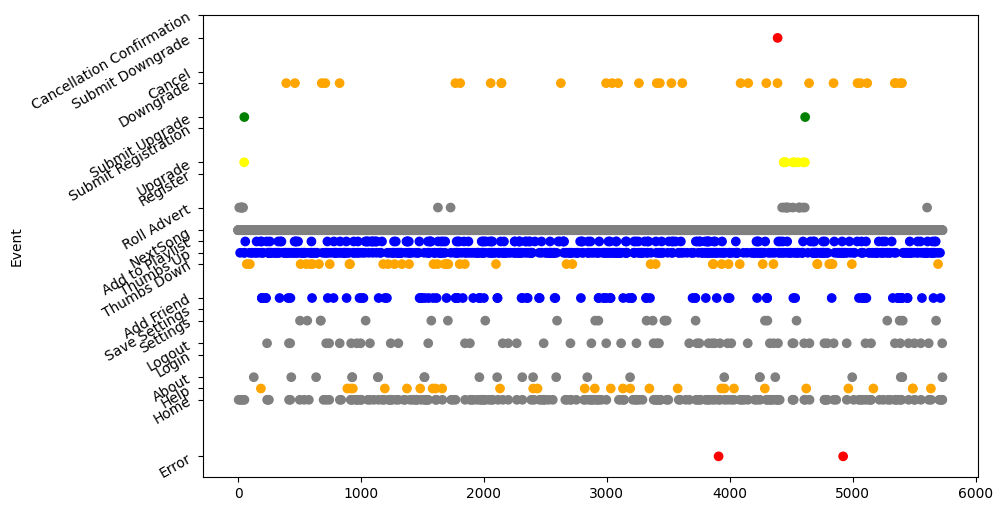

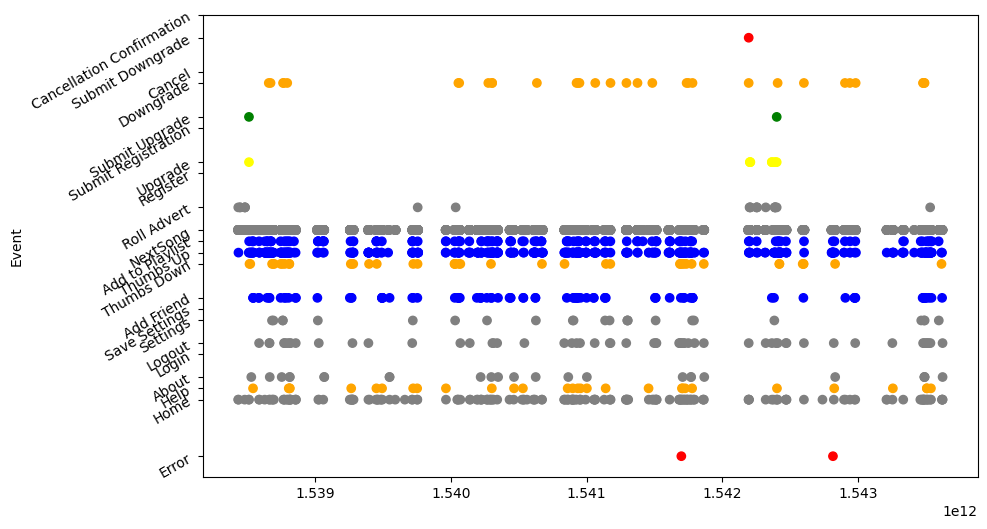

user 141


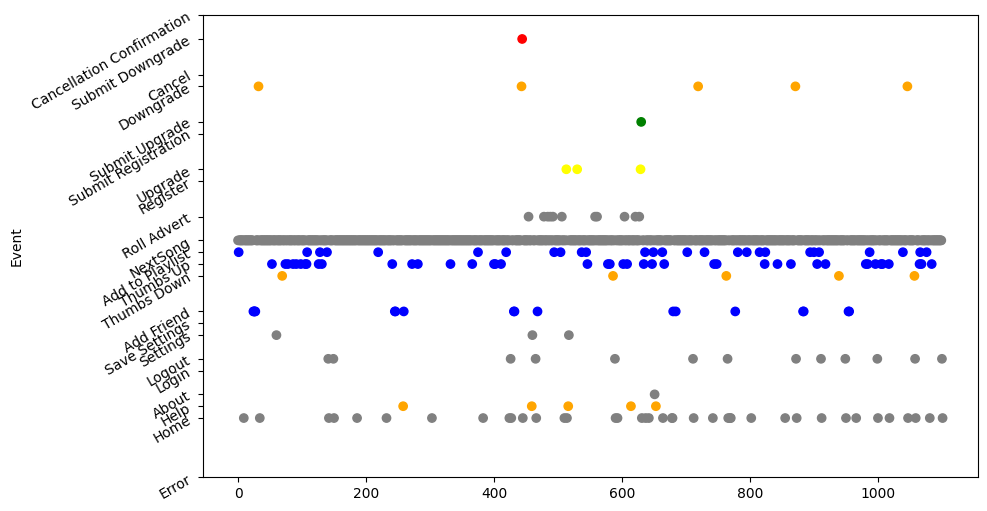

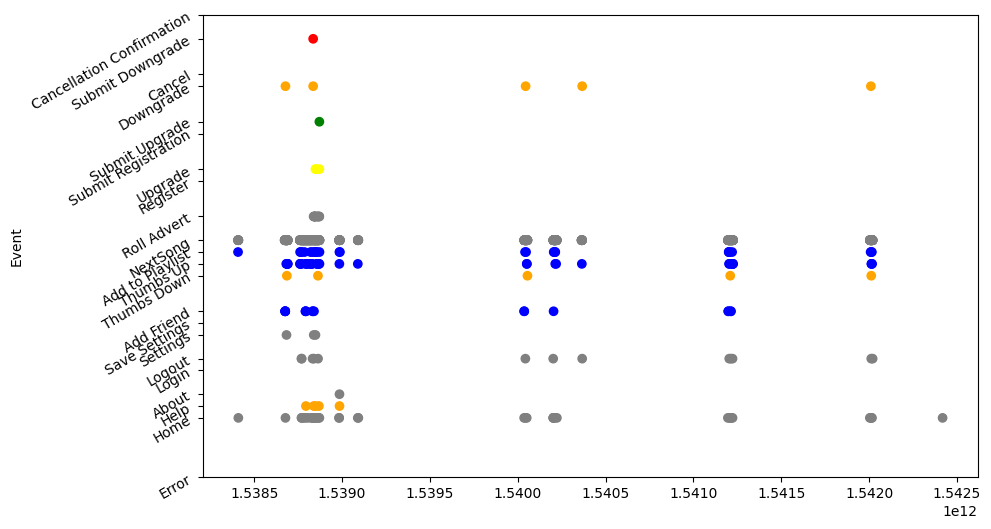

user 51


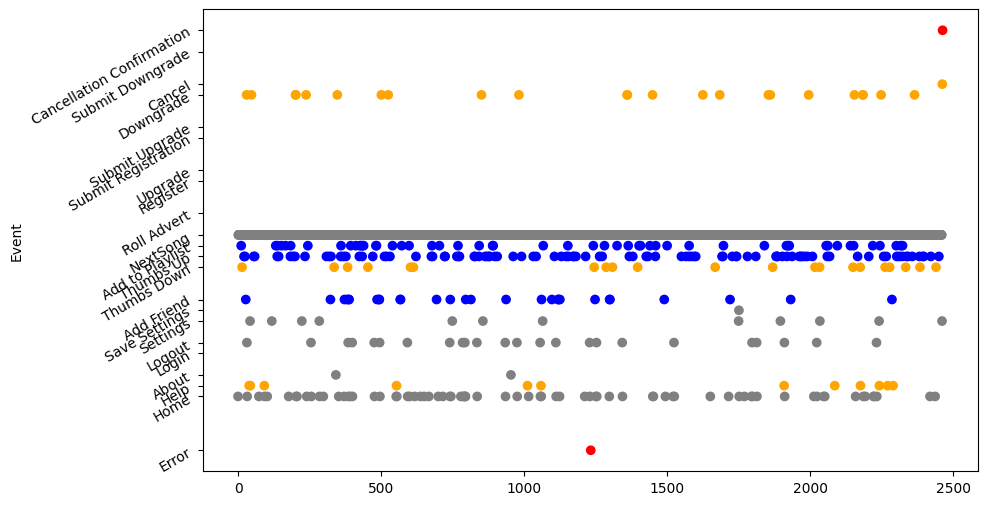

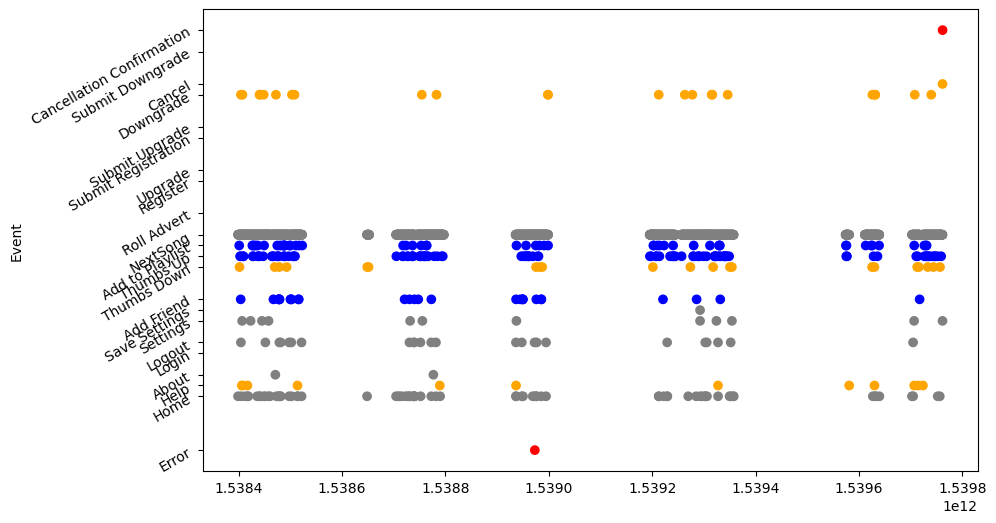

user 300007


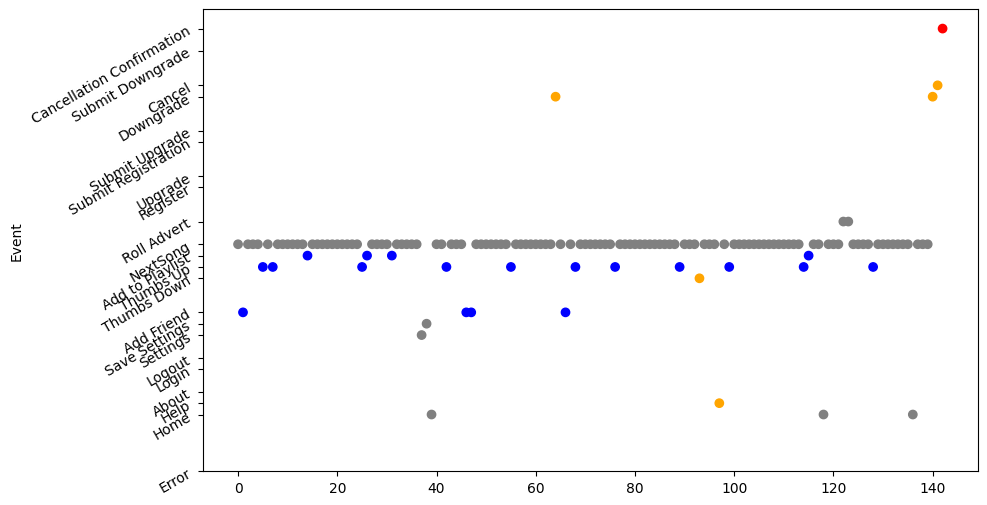

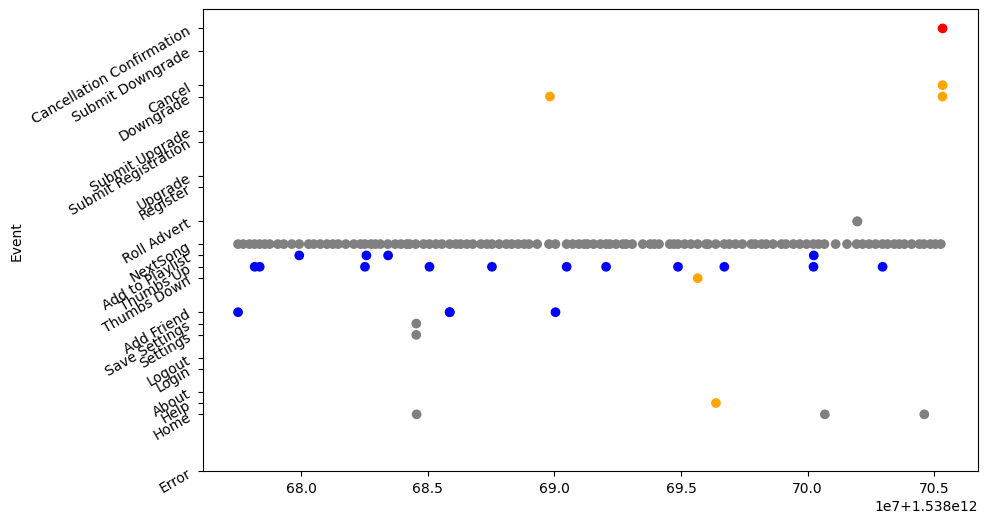

user 100024


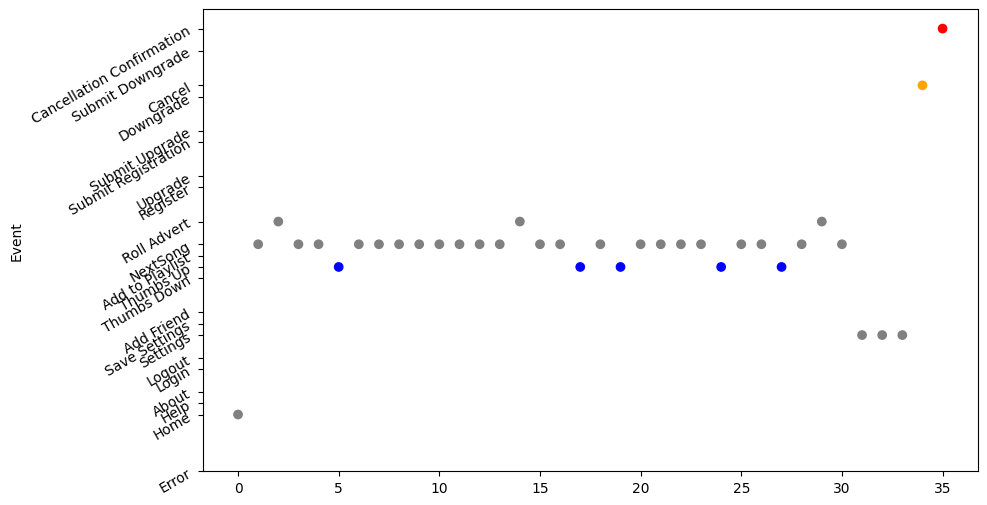

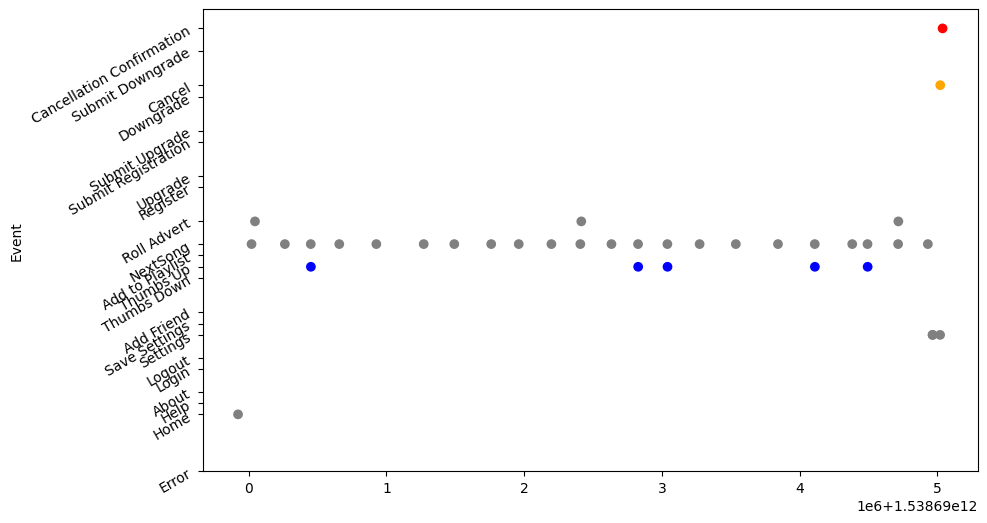

user 143


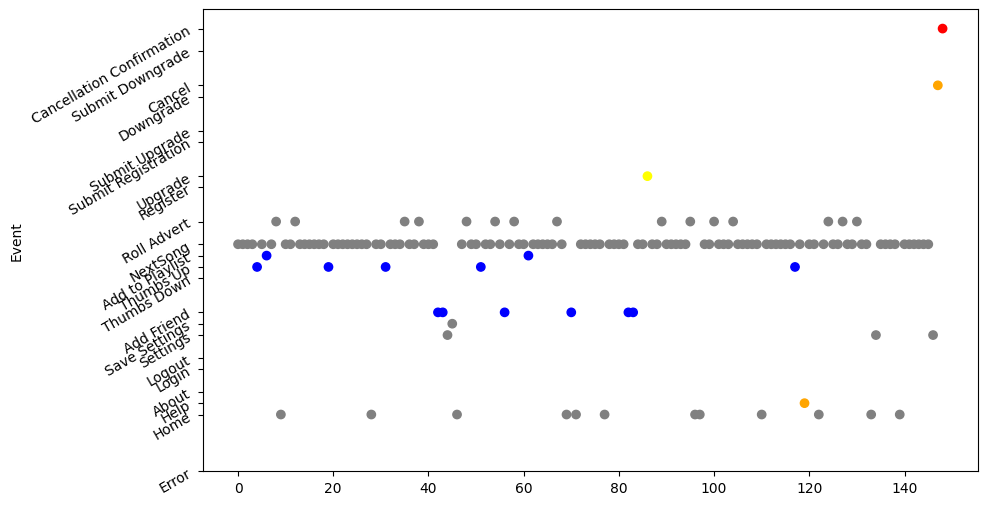

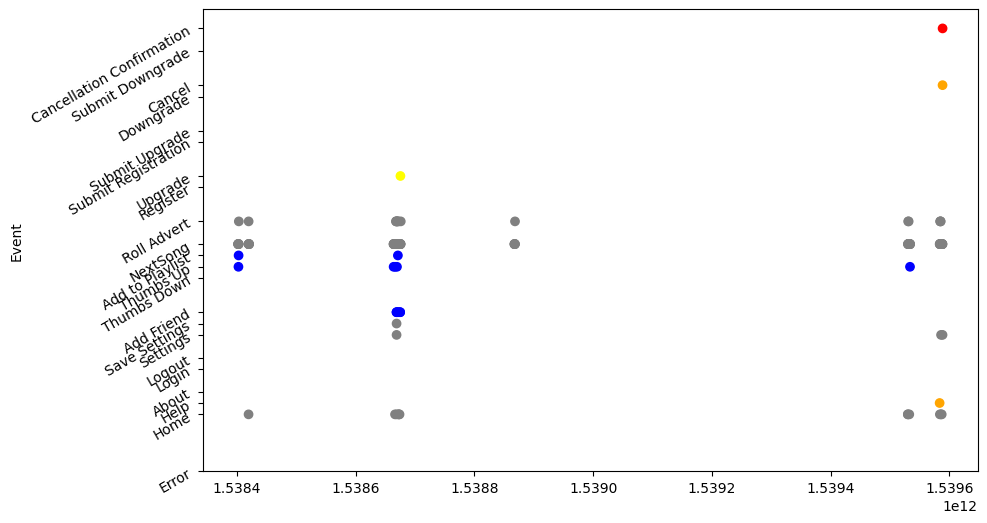

user 200021


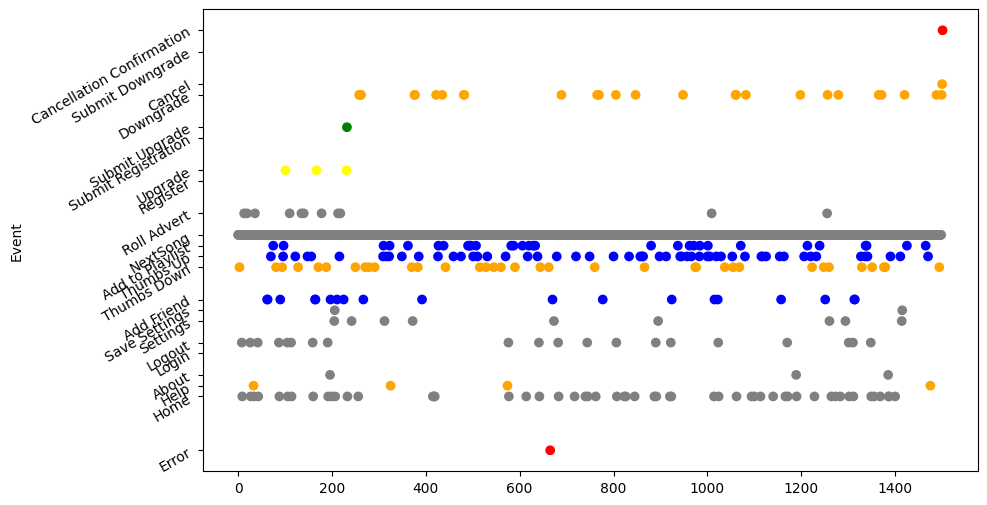

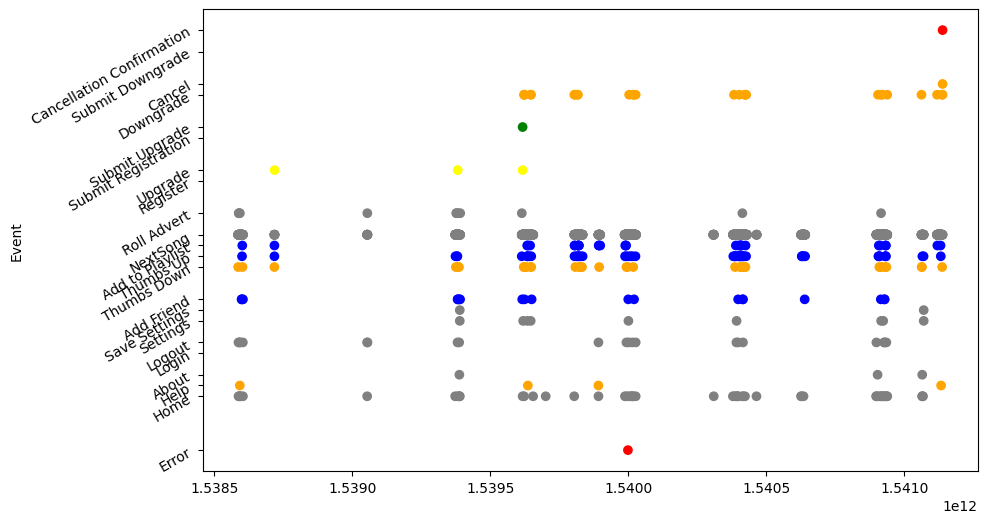

In [26]:
for uid in user_ids_selected:
    print(f"user {uid}")
    plot_user_events(uid)

In [7]:
spark.stop()